<a href="https://colab.research.google.com/github/mianzha/data-mining-/blob/main/datamining_shixuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toulouse (FR) Street names - Gender analysis

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pip install plotly.express

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Domain knowledge

In [ ]:
# Domain specific stopwords (not relevant for prediction)
stopwords = set(["aux", "de", "des", "del", "dit", "du", "en", "et", "la", "las", "le", # mots de liaison
                 "allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", "cour", "clos", # type voie
                 "enclos", "place", "passage", "pont", "quai", "rond-point", "rue", "square", "tunnel", "voie", # type voie
                 "faubourg", "route", "via", "puits", "jeu",
                 "bassin", "bois", "colline", "croix", "fontaine", "esplanade", "jardin", # environement
                 "château", "ecole", "ecoles", "espace", "loge", "moulin", "mas", "palais", "parvis", "passerelle", # environement
                 "jardins", "parc", "parking", "petit", "petite", "plan",  "tour", # environement
                 "blanc", "rouge", "roses", "vieille", "bon",
                 "deux", "quatre", # chiffres
                 "toulouse", "balma", # villes
                 "cheval", "merle", # animaux
                 "belle", "val", "mai" # prenoms from data.gouv.fr (ambigu)
                ])

In [ ]:
# Prenom & genre de data.gouv.fr
url0 = "https://static.data.gouv.fr/resources/liste-de-prenoms/20141127-154433/Prenoms.csv"
names = pd.read_csv(url0, encoding = "latin", sep=";", usecols=["01_prenom", "02_genre"], index_col="01_prenom")
names = names.to_dict()['02_genre'] # mapping from name to gender, ex: Anne -> 'f' (or 'm', 'm,f')

In [ ]:
# Extra women names/patterns (not in data.gouv.fr list)
for w in ["sainte", "simone"]:
    names[w] = "f"

In [ ]:
# Extra men names/patterns (not in data.gouv.fr list)
for w in ["alexis", "antonin", "claude", "edouard", "emile", "etienne", "fabre", "francis",
          "hippolyte", "guilhem", "jean", "jules", "georges",  # <!> exceptions, georges sand
          "abbé", "père", "pasteur", # professions religieuse au masculin
          "colonel", "général", "maréchal", # professions militaire au masculin
          "professeur", "docteur", # autres professions au masculin
          "comte", "frères", "roi", # autres, statut social au masculin
          "saint"]:
    names[w] = "m"

# 1. Prepare dataset

In [ ]:
def load_dataset(url: str):
    """
    Args:
        url: str, a link pointing a csv file, e.g., at data.montpellier3m.fr or opendata.paris.fr
    Returns:
        df: pd.DataFrame, a table containing street names as rows (along with lat, long)
    """

    # read dataset
    df = pd.read_csv(url, sep=";")

    # keep relevant columns
    df = df[['code_insee', 'commune', 'libelle', 'Geo Point']]

    # drop duplicate rows (group addresses --> average latitudes and longitudes to get coordinates of center)
    df = df.groupby(by=['code_insee', 'commune', 'libelle']).mean()

    # reset index
    df = df.reset_index()
    return df

# 2. Label street names

In [ ]:
def label_street(name: str):
    """
    Args:
        name: str, street name
    Returns:
        label: int, 0 (no gender), 1 (M), 2 (F), 1.5 (uncertain or mixed H/F)
    """

    # preprocess string (lower case, remove digits and punctuation)
    name = name.lower()
    for d in "0123456789-'":
        name = name.replace(d, ' ')

    # iterate over each street words and return 1 (resp 2) if M (resp F) pattern for first name (prenom A)
    for w in name.split():
        w = w.strip() # remove extra white spaces
        if w not in stopwords and w in names:
            gender = names[w]
            if gender == 'f':
                return 2
            elif gender == 'm':
                return 1
    return 0 # no label

In [ ]:
### CODE POUR TOULOUSE

# L'URL du fichier CSV
url = "https://data.toulouse-metropole.fr/explore/dataset/numero-de-rue/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true"

# Charger les données dans un DataFrame pandas
df1 = pd.read_csv(url, sep=';')

# Afficher les premières lignes du DataFrame
df1.head()


Geo Point  \
0   43.52466655143368,1.3510933904857767   
1   43.56930329926469,1.4089977966014127   
2   43.62556081240441,1.4581329402854533   
3   43.69135851593371,1.4155960129848741   
4  43.605201288103174,1.4596209828168392   

                                           Geo Shape  numero repetition  \
0  {"coordinates": [[1.351093390485777, 43.524666...      19        NaN   
1  {"coordinates": [[1.408997796601413, 43.569303...      50        NaN   
2  {"coordinates": [[1.458132940285453, 43.625560...      22        NaN   
3  {"coordinates": [[1.415596012984874, 43.691358...       5        NaN   
4  {"coordinates": [[1.459620982816839, 43.605201...      11        NaN   

  num_long                     libelle           sti       rivoli  \
0     0019  RUE ROBERT LOUIS STEVENSON  315880000174  3105880831W   
1     0050              RUE DE LONDRES  315554176036  3105555324Y   
2     0022            RUE DE LA VIERGE  315557238442  3105558864W   
3     0005  RUE SAINT REMY DE PROVENCE  314670000111  3104670426G   
4     0011        RUE DE LA PROVIDENCE  315555625620  3105557172G   

   code_postal              commune  code_insee  
0        31270  VILLENEUVE TOLOSANE       31588  
1        31100             TOULOUSE       31555  
2        31500             TOULOUSE       31555  
3        31140          SAINT ALBAN       31467  
4        31500             TOULOUSE       31555

In [ ]:
df = df1

In [ ]:
df["long"] = df['Geo Point'].str.split(",", expand = True)[1].astype(float)
df["lat"] = df['Geo Point'].str.split(",", expand = True)[0].astype(float)

In [ ]:
###Keep columns and drop duplicates
df = df[['code_insee', 'commune', 'libelle', 'code_postal','long', 'lat']]

df = df.groupby(by=['code_insee', 'commune','code_postal', 'libelle']).mean()

df = df.reset_index()

In [ ]:
df.head()

code_insee       commune  code_postal                libelle      long  \
0       31003  AIGREFEUILLE        31280    ALLEE DES FENAISONS  1.582288   
1       31003  AIGREFEUILLE        31280     ALLEE DES MOISSONS  1.583696   
2       31003  AIGREFEUILLE        31280     ALLEE DES PYRENEES  1.586720   
3       31003  AIGREFEUILLE        31280    ALLEE DES VENDANGES  1.586880   
4       31003  AIGREFEUILLE        31280  ALLEE DU MONT VALLIER  1.585248   

         lat  
0  43.568279  
1  43.567516  
2  43.565934  
3  43.567017  
4  43.566446

In [ ]:
print(df)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat  
0     1.582288  43.568279  
1     1.583696  43.

In [ ]:
df.dtypes

code_insee       int64
commune         object
code_postal      int64
libelle         object
long           float64
lat            float64
dtype: object

In [ ]:
# Test on Toulouse (FR) street names
df["label"] = df['libelle'].apply(label_street)
df.head()

code_insee       commune  code_postal                libelle      long  \
0       31003  AIGREFEUILLE        31280    ALLEE DES FENAISONS  1.582288   
1       31003  AIGREFEUILLE        31280     ALLEE DES MOISSONS  1.583696   
2       31003  AIGREFEUILLE        31280     ALLEE DES PYRENEES  1.586720   
3       31003  AIGREFEUILLE        31280    ALLEE DES VENDANGES  1.586880   
4       31003  AIGREFEUILLE        31280  ALLEE DU MONT VALLIER  1.585248   

         lat  label  
0  43.568279      0  
1  43.567516      0  
2  43.565934      0  
3  43.567017      0  
4  43.566446      0

# 3. Analysis

## 3.1 Names distribution / language model

In [ ]:
def get_sorted_vocab(corpus):
    """
    Args:
        corpus: list of str
    Returns:
        vocab: list of str, words in corpus
        counts: list of int, word counts
    """

    # save word counts as a dictionnary
    counts_dict = {}
    for name in corpus:
        for w in name.split():
            w = w.lower().strip()
            if w not in stopwords and len(w)>0:
                if w in counts_dict:
                    counts_dict[w] +=1
                else:
                    counts_dict[w] =1

    # sort vocabulary by counts
    names = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    sorted_idx = np.argsort(counts)[::-1]
    return names[sorted_idx], counts[sorted_idx], counts_dict

In [ ]:
# get vocabulary and word counts
corpus = df['libelle'].values
vocab, counts, counts_dict = get_sorted_vocab(corpus)
print('{} words found'.format(len(counts)))
print(' {} words occur 2+ times (total counts {})'.format(len([c for c in counts if c>1]), sum([c for c in counts if c>1])))
print(" Louis in vocab:", "louis" in vocab) # test if name in vocab

5207 words found
 1882 words occur 2+ times (total counts 10234)
 Louis in vocab: True


In [ ]:
print(corpus)

['ALLEE DES FENAISONS' 'ALLEE DES MOISSONS' 'ALLEE DES PYRENEES' ...
 'RUE VICTOR HUGO' 'RUE VOLTAIRE' 'VIEUX CHEMIN DE MURET']


In [ ]:
# inspect data (2+ occurence and not labeled as masculin or feminin)
#for i in range(len(vocab)):
#    if counts[i]>1 and label_street(vocab[i]) == 0:
#        print(vocab[i], counts[i])

### 3.1.1 Femmes vs Homme names dans le top 50 et top 100

In [ ]:
def print_stats_topk(k: int = 100):
    sorted_labels = [label_street(w) for w in vocab if label_street(w) in [1.0, 2.0]]
    topk_m = len([l for l in sorted_labels[:k] if l == 1.0])
    topk_f = len([l for l in sorted_labels[:k] if l == 2.0])
    ratio_topk = 100*topk_f/(topk_m+topk_f)
    print("Top{} names 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(k, topk_f, topk_m, ratio_topk))

In [ ]:
print_stats_topk(k=50)
print_stats_topk(k=100)

Top50 names 'F' = 4 vs. 'M' = 46 (8.0% representativité)
Top100 names 'F' = 17 vs. 'M' = 83 (17.0% representativité)


### 3.1.2 Word distribution and gender bias

In [ ]:
# plot power law, long tail distribution and bias (color blue M, red W, gray No Label)
def plot_word_distr(offset: int = 0, limit: int = 50):
    plt.figure(1, figsize=(15,5))
    color = {0: "gray", 1: "blue", 2: "red"}
    colors = [color[label_street(w)] for w in vocab[offset:offset+limit]]
    plt.scatter(np.arange(limit), counts[offset:offset+limit], c=colors)
    plt.plot(counts[offset:offset+limit], color="gray", linestyle='dashed')
    plt.xticks(np.arange(limit), vocab[offset:offset+limit], rotation=45)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    plt.ylabel("counts")
    plt.title("Toulouse (FR) - Common street names sorted by counts ({}-{})".format(offset,offset+limit))
    plt.show()

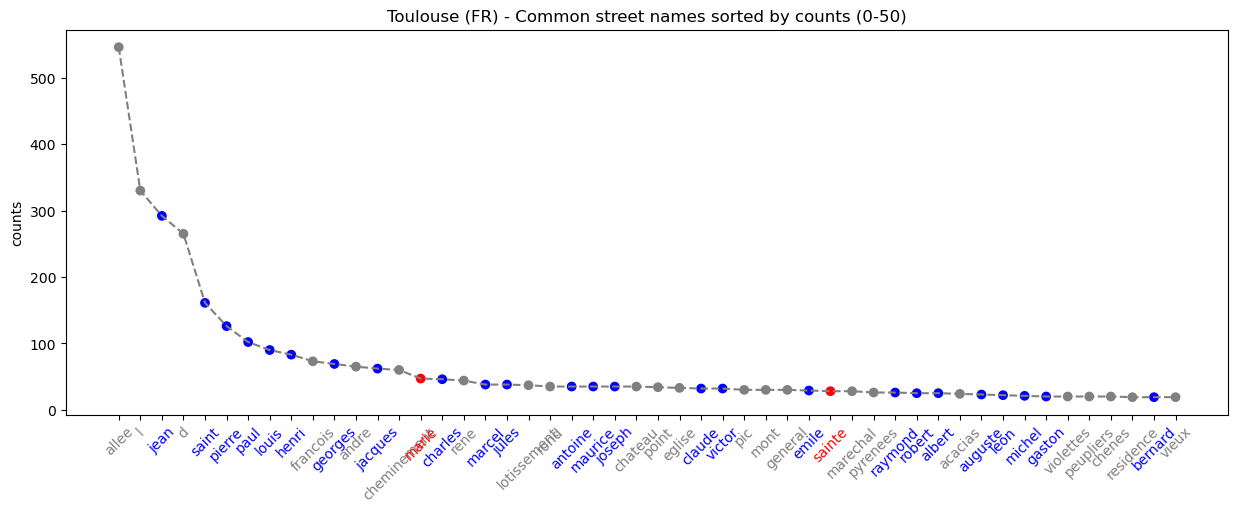

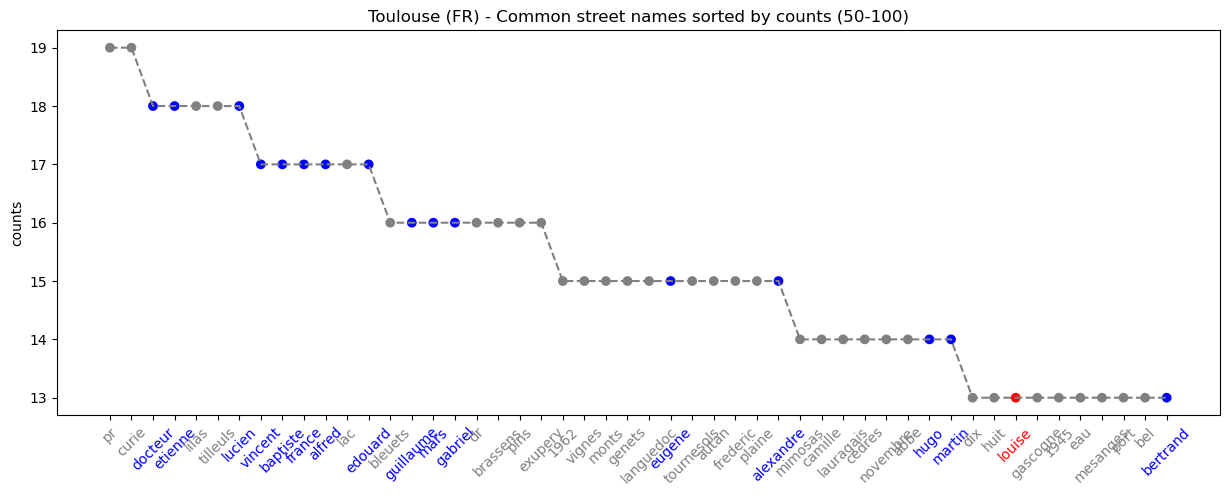

In [ ]:
plot_word_distr(offset=0, limit=50)
plot_word_distr(offset=50, limit=50)

## 3.2 Gender bias - Street statistics

In [ ]:
print(len(df), 'streets in Toulouse')

8638 streets in Toulouse


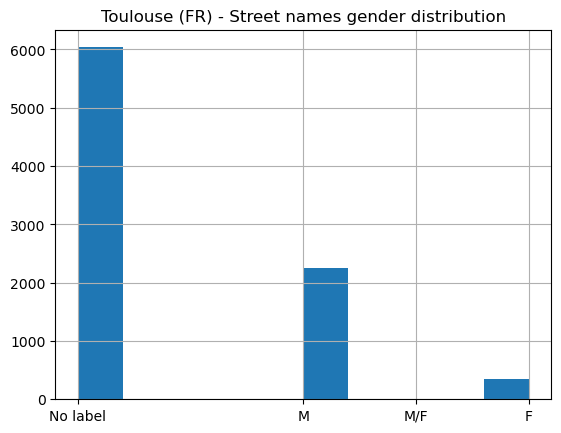

In [ ]:
 #plot distribution (street names gender distribution)
df["label"].hist()
plt.title("Toulouse (FR) - Street names gender distribution")
plt.xticks([0,1,1.5,2], ["No label", "M", "M/F", "F"])
plt.show()

### 3.2.1 Rues portant des noms de Femme vs Homme

Note: Statistique sensible à l'algorithme de classification

In [ ]:
n_street_f = len(df[df["label"]==2]) # ex: Square Edith Piaf
n_street_m = len(df[df["label"]==1]) # ex: Boulevard Paul Valéry
ratio_f = 100*n_street_f/(n_street_m + n_street_f)

In [ ]:
print("Street 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(n_street_f, n_street_m, ratio_f))

Street 'F' = 348 vs. 'M' = 2252 (13.4% representativité)


### 3.2.2 Rues nommées Sainte vs. Saint ...

Solution la plus simple pour calculer le biais dans une commune / métropole. Limite: High variance estimator (low n sample)

In [ ]:
n_occurence_ste = counts_dict["sainte"] # ex: 'Sainte Genevieve'
n_occurence_st = counts_dict["saint"] # ex: 'Saint Pierre'
ratio_ste = 100*n_occurence_ste/(n_occurence_st+n_occurence_ste)

In [ ]:
print("Occurence 'Ste' = {} vs. 'St' = {} ({:.1f}% representativité)".format(n_occurence_ste, n_occurence_st, ratio_ste))

Occurence 'Ste' = 28 vs. 'St' = 161 (14.8% representativité)


## 3.3 Analyse par type de voie

In [ ]:
# distribution par type de voie (square, avenue, boulevard...)
types_de_voie = ["allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", # type voie
                 "place", "passage", "pont", "quai", "rond-point", "rue", "square", # type voie
                 "fontaine", "esplanade", "espace", "loge", # environement
                 "parvis", "passerelle", "jardins", "parc",
                ]

df["voie_type"] = "autre"
for v in types_de_voie:
    df.loc[df["libelle"].str.lower().str.contains(v+" "), "voie_type"] = v

In [ ]:
df["F"] = 0
df["M"] = 0
df.loc[df["label"].astype(int)==2, "F"] = 1
df.loc[df["label"].astype(int)==1, "M"] = 1

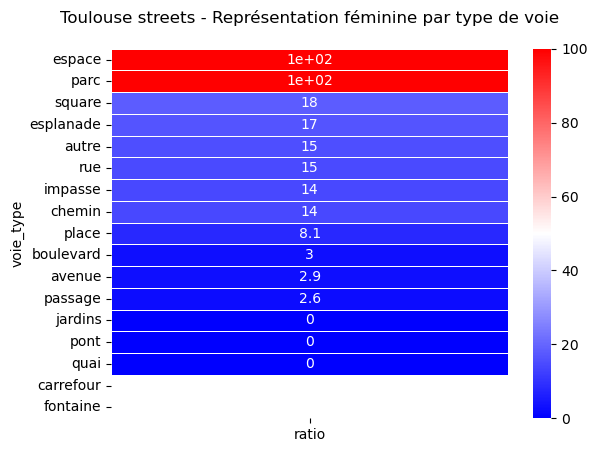

In [ ]:
df_by_type = df[["voie_type", "F", "M"]].groupby(["voie_type"]).sum()
df_by_type["ratio"] = 100*df_by_type["F"]/(df_by_type["F"]+df_by_type["M"])
df_by_type = df_by_type.sort_values(["ratio"], ascending=False)

# plot representation by type of voie
sns.heatmap(df_by_type[["ratio"]], cmap='bwr', linewidths=0.5, annot=True)
plt.title("Toulouse streets - Représentation féminine par type de voie\n")
plt.show()

## 3.4 Geospatial analysis

### 3.4.1 [Toulouse](https://data.toulouse-metropole.fr/explore/dataset/numero-de-rue/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true), Occitanie

In [ ]:
# rename label 0, 1, 2... for visualization
df["label"] = df["label"].astype(int)
df.loc[df["label"]==0, "label"] = "None"
df.loc[df["label"]==1, "label"] = "M"
df.loc[df["label"]==2, "label"] = "F"
#df.loc[df["label"]==1.5, "label"] = "M/F"

In [ ]:
fig = px.scatter_mapbox(df, lat="lat", lon="long", zoom=12,
                        color="label",
                        color_discrete_map={
                            "None":"#000000", # black
                            "M":"#0000FF", # blue
                            "F":"#FF0000", # red
                            "M/F":"#A020F0", # violet
                        },
                        #size="type_de_voie",
                        size_max=10,
                        opacity=0.5,
                        hover_name="libelle",
                        hover_data={
                            "lat":":.3f",
                            "long":":.3f",
                            "label": True,
                            "libelle": True
                        },
                        mapbox_style = "stamen-toner", # no token required for 'open-street-map', 'carto-positron', 'stamen-toner'
                        title="{} streets - Gender analysis".format(df["commune"][0]),
                        height=750, # figure height in pixel
                       )
fig.show()

In [ ]:
#Machine learning

In [ ]:
prenoms_df  = pd.read_csv(url0, encoding = "latin", sep=";", usecols=["01_prenom", "02_genre","03_langage"])

In [ ]:
prenoms_df.head()

01_prenom 02_genre        03_langage
0   aaliyah        f  english (modern)
1    aapeli        m           finnish
2      aapo        m           finnish
3     aaren      m,f           english
4     aarne        m           finnish

In [ ]:
#data cleaning(Avant TF-IDF)
# Recharger les bibliothèques et les données car l'environnement d'exécution a été réinitialisé
import pandas as pd

# Calculer le ratio des prénoms ayant deux genres
total_names =  prenoms_df.shape[0]
dual_gender_names =  prenoms_df[ prenoms_df['02_genre'] == 'm,f'].shape[0]
dual_gender_ratio = dual_gender_names / total_names

dual_gender_ratio



0.02485593876322353

In [ ]:
# Filtrer les prénoms ayant deux genres
#  'm,f' ,'f,m'
prenoms_filtrés_df = prenoms_df[(prenoms_df['02_genre'] != 'm,f') & (prenoms_df['02_genre'] != 'f,m')]

# Préparer quelques prénoms supplémentaires avec des genres connus (à titre d'exemple)
noms_supplémentaires = [
    {"01_prenom": "Jean", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Marie", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Pierre", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Sophie", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "François", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Élise", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Luc", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Sylvie", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Philippe", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Isabelle", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Michel", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Catherine", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "David", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Laurence", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Olivier", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Nathalie", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Éric", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Valérie", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Sébastien", "02_genre": "m", "03_langage": "français", "04_fréquence": 0.0},
    {"01_prenom": "Caroline", "02_genre": "f", "03_langage": "français", "04_fréquence": 0.0}
]

# Convertir ces noms supplémentaires en DataFrame et les fusionner avec l'ensemble de données existant
noms_supplémentaires_df = pd.DataFrame(noms_supplémentaires)
prenoms_combinés_df = pd.concat([prenoms_filtrés_df, noms_supplémentaires_df], ignore_index=True)

# Afficher les premières lignes de l'ensemble de données combiné
prenoms_combinés_df.head()


01_prenom 02_genre        03_langage  04_fréquence
0   aaliyah        f  english (modern)           NaN
1    aapeli        m           finnish           NaN
2      aapo        m           finnish           NaN
3     aarne        m           finnish           NaN
4     aarón        m           spanish           NaN

In [ ]:
# Supprimer les apostrophes des prénoms
prenoms_combinés_df['01_prenom'] = prenoms_combinés_df['01_prenom'].str.replace("'", "")

# Supprimer le contenu entre parenthèses dans '01_prenom' ainsi que les parenthèses elles-mêmes, puis supprimer les espaces en début et en fin de chaîne
prenoms_combinés_df['01_prenom'] = prenoms_combinés_df['01_prenom'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# Supprimer les lignes complètement identiques sur '01_prenom' et '02_genre' (conserver une copie)
prenoms_combinés_df.drop_duplicates(subset=['01_prenom', '02_genre'], keep='first', inplace=True)

# Supprimer les lignes où '01_prenom' est identique mais '02_genre' est différent
prenoms_combinés_df.drop_duplicates(subset=['01_prenom'], keep=False, inplace=True)

# Vérifier les '01_prenom' et '02_genre' avec des valeurs manquantes
valeurs_manquantes = prenoms_combinés_df[['01_prenom', '02_genre']].isnull().any(axis=1)

# Afficher les lignes contenant des valeurs manquantes
print("Lignes contenant des valeurs manquantes :")
print(prenoms_combinés_df[valeurs_manquantes])

# Supprimer les lignes contenant des valeurs manquantes
prenoms_combinés_df.dropna(subset=['01_prenom', '02_genre'], inplace=True)


Lignes contenant des valeurs manquantes :
     01_prenom 02_genre 03_langage  04_fréquence
7577       NaN        f    english           NaN


In [ ]:
# Créer une nouvelle base de données 'prenom_reference'
prenom_reference = prenoms_combinés_df.copy()
prenom_reference.head()

01_prenom 02_genre        03_langage  04_fréquence
0   aaliyah        f  english (modern)           NaN
1    aapeli        m           finnish           NaN
2      aapo        m           finnish           NaN
3     aarne        m           finnish           NaN
4     aarón        m           spanish           NaN

In [ ]:
print(prenom_reference)

       01_prenom 02_genre        03_langage  04_fréquence
0        aaliyah        f  english (modern)           NaN
1         aapeli        m           finnish           NaN
2           aapo        m           finnish           NaN
3          aarne        m           finnish           NaN
4          aarón        m           spanish           NaN
...          ...      ...               ...           ...
11206   nathalie        f          français           0.0
11207       éric        m          français           0.0
11208    valérie        f          français           0.0
11209  sébastien        m          français           0.0
11210   caroline        f          français           0.0

[11052 rows x 4 columns]


In [ ]:
langues_retenues = ['english (modern)', 'english', 'english, biblical', 'biblical', 'english, jewish',
                    'english, french, spanish, biblical', 'african', 'english, german, biblical',
                    'french, italian', 'ancient greek (latinized)', 'greek mythology (latinized)',
                    'english, french, german, polish, russian, romanian, biblical', 'french', 'astronomy',
                    'history', 'theology', 'english, romanian, russian', 'italian, spanish, portuguese, romanian, english',
                    'anglo-saxon', 'ancient roman', 'english, scottish', 'italian, spanish', 'english, german',
                    'english, french', 'english, italian', 'italian, german, portuguese, english',
                    'italian, spanish, portuguese', 'french, portuguese, hungarian', 'french, portuguese',
                    'french, english, german, scandinavian','français']

# Sélection des lignes correspondant aux langues retenues
prenom_reference_retenu= prenom_reference[prenom_reference['03_langage'].isin(langues_retenues)]


In [ ]:
prenom_reference_retenu.head()

01_prenom 02_genre         03_langage  04_fréquence
0    aaliyah        f   english (modern)           NaN
5      aaron        m  english, biblical           NaN
9    abaddon        m           biblical           NaN
12     abbey        f            english           NaN
13     abbie        f            english           NaN

In [ ]:
# Vérifier les valeurs manquantes dans la colonne 'prenom'
missing_values = prenom_reference_retenu['01_prenom'].isna().sum()

# Afficher le nombre de valeurs manquantes
print(f"Nombre de valeurs manquantes dans la colonne 'prenom': {missing_values}")

Nombre de valeurs manquantes dans la colonne 'prenom': 0


In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Extraire les prénoms
names = prenom_reference_retenu['01_prenom']

# Appliquer la vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer()
name_vectors = tfidf_vectorizer.fit_transform(names)

# Afficher les dimensions du résultat de la vectorisation (voir combien de fonctionnalités ont été créées)
name_vectors.shape


print(name_vectors)
#chaque lettre a-z et des combinaisons a-b/a-c

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (3833, 3817)	1.0
  (3834, 3819)	1.0
  (3835, 3820)	1.0
  (3836, 3821)	1.0
  (3837, 3822)	1.0
  (3838, 1756)	1.0
  (3839, 2446)	1.0
  (3840, 2925)	1.0
  (3841, 3342)	1.0
  (3842, 1326)	1.0
  (3843, 3835)	1.0
  (3844, 2316)	1.0
  (3845, 3407)	1.0
  (3846, 2908)	1.0
  (3847, 1650)	1.0
  (3848, 2577)	1.0
  (3849, 621)	1.0
  (3850, 896)	1.0
  (3851, 2144)	1.0
  (3852, 2772)	1.0
  (3853, 2664)	1.0
  (3854, 3841)	1.0
  (3855, 3637)	1.0
  (3856, 3409)	1.0
  (3857, 602)	1.0


In [ ]:
#chaque nom est completement different et identique
#le modèle ne peut pas apprendre des connaissances généralisables d'un nom à l'autre

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les derniers mots en vecteurs numériques
# Transformer les prénoms en vecteurs numériques
X = vectorizer.fit_transform(prenom_reference_retenu['01_prenom'])

# Créer un DataFrame avec les vecteurs numériques
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Afficher les premières lignes du DataFrame résultant
df_features.head()

a  b  c  d  e  f  g  h  i  j  ...  zq  zr  zs  zt  zu  zv  zw  zx  zy  zz
0  3  0  0  0  0  0  0  1  1  0  ...   0   0   0   0   0   0   0   0   0   0
1  2  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
2  2  1  0  2  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
3  1  2  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   0
4  1  2  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   0

[5 rows x 702 columns]

In [ ]:
# Ajouter le nouveau DataFrame de caractéristiques à la dataframe d'origine
prenom_reference_retenu_extended = pd.concat([prenom_reference_retenu.reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)

# Afficher le résultat
print(prenom_reference_retenu_extended.head())


  01_prenom 02_genre         03_langage  04_fréquence  a  b  c  d  e  f  ...  \
0   aaliyah        f   english (modern)           NaN  3  0  0  0  0  0  ...   
1     aaron        m  english, biblical           NaN  2  0  0  0  0  0  ...   
2   abaddon        m           biblical           NaN  2  1  0  2  0  0  ...   
3     abbey        f            english           NaN  1  2  0  0  1  0  ...   
4     abbie        f            english           NaN  1  2  0  0  1  0  ...   

   zq  zr  zs  zt  zu  zv  zw  zx  zy  zz  
0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0   0   0  
2   0   0   0   0   0   0   0   0   0   0  
3   0   0   0   0   0   0   0   0   0   0  
4   0   0   0   0   0   0   0   0   0   0  

[5 rows x 706 columns]


In [ ]:
# supprimer '01_prenom'et'04_fréquence','03_langage'
prenom_reference_retenu_extended = prenom_reference_retenu_extended.drop(['01_prenom', '03_langage','04_fréquence'], axis=1)
print(prenom_reference_retenu_extended)

     02_genre  a  b  c  d  e  f  g  h  i  ...  zq  zr  zs  zt  zu  zv  zw  zx  \
0           f  3  0  0  0  0  0  0  1  1  ...   0   0   0   0   0   0   0   0   
1           m  2  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
2           m  2  1  0  2  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
3           f  1  2  0  0  1  0  0  0  0  ...   0   0   0   0   0   0   0   0   
4           f  1  2  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   0   
...       ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
3853        f  2  0  0  0  1  0  0  1  1  ...   0   0   0   0   0   0   0   0   
3854        m  0  0  1  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   0   
3855        f  1  0  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   0   
3856        m  1  1  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   0   
3857        f  1  0  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   0   

      zy  zz  
0      0   0

In [ ]:
#Problème de découpage de l'ensemble de données dans la conception expérimentale pour l'apprentissage automatique
#（Utilisation de la validation croisée avec 5 plis）
#literature:Name based Gender Identification using Machine Learning and Deep Learning ModelsDeep Learning Models-Ghosh, Ritwick (2022)
#Dans chaque test, 1/5 est dédiée aux données de validation/test, tandis que les quatre autres servent d'ensemble d'entraînement.
#Ce processus est répété cinq fois, chaque 1/5 partie étant utilisée une seule fois comme ensemble de validation.
#réduire le risque de surajustement et fournit une estimation plus précise des performances de généralisation du modèle.
#De plus, l'utilisation de la valeur de l'état aléatoire 42 garantit que les données sont divisées de manière reproductible

In [ ]:
##Deux models:svm/random forest and SVM ,Xgboost

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convertir les étiquettes de genre en forme numérique

In [ ]:
# Convertir les étiquettes de genre en forme numérique
le = LabelEncoder()
gender_labels = le.fit_transform(prenom_reference_retenu_extended['02_genre'])
prenom_reference_retenu_extended['02_genre'] = le.fit_transform(prenom_reference_retenu_extended['02_genre'])

In [ ]:
# Afficher les classes et leur encodage correspondant
#"f" a été encodé comme 0 ,"m" comme 1
print(list(le.classes_))

['f', 'm']


In [ ]:
print(prenom_reference_retenu_extended)

      02_genre  a  b  c  d  e  f  g  h  i  ...  zq  zr  zs  zt  zu  zv  zw  \
0            0  3  0  0  0  0  0  0  1  1  ...   0   0   0   0   0   0   0   
1            1  2  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   
2            1  2  1  0  2  0  0  0  0  0  ...   0   0   0   0   0   0   0   
3            0  1  2  0  0  1  0  0  0  0  ...   0   0   0   0   0   0   0   
4            0  1  2  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   
...        ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..   
3853         0  2  0  0  0  1  0  0  1  1  ...   0   0   0   0   0   0   0   
3854         1  0  0  1  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   
3855         0  1  0  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   
3856         1  1  1  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   
3857         0  1  0  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   

      zx  zy  zz  
0      0   0   0  
1      0   0   0  
2     

In [ ]:
# Tout d'abord, séparer les caractéristiques et les étiquettes cibles de df
X = prenom_reference_retenu_extended.drop(['02_genre'], axis=1)  # Supprimer la colonne des étiquettes pour obtenir l'ensemble des caractéristiques
y = prenom_reference_retenu_extended['02_genre']  # Ensemble des étiquettes cibles


In [ ]:
print(X)


      a  b  c  d  e  f  g  h  i  j  ...  zq  zr  zs  zt  zu  zv  zw  zx  zy  \
0     3  0  0  0  0  0  0  1  1  0  ...   0   0   0   0   0   0   0   0   0   
1     2  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
2     2  1  0  2  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  2  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     1  2  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
3853  2  0  0  0  1  0  0  1  1  0  ...   0   0   0   0   0   0   0   0   0   
3854  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
3855  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
3856  1  1  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
3857  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      zz  
0      0  
1      0  
2      0  
3      

In [ ]:
print(y)

0       0
1       1
2       1
3       0
4       0
       ..
3853    0
3854    1
3855    0
3856    1
3857    0
Name: 02_genre, Length: 3858, dtype: int32


In [ ]:
# Initialiser les modèles
svm = SVC(random_state=42)  # Support Vector Machine (SVM)
rf = RandomForestClassifier(random_state=42)  # Forêt aléatoire (Random Forest)
xgb_model = xgb.XGBClassifier(random_state=42)  # XGBoost

# Configurer la validation croisée stratifiée à 5 plis
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Validation croisée stratifiée à 5 plis


In [ ]:
# Définir la fonction d'évaluation du modèle
def evaluate_model(model, X, y, cv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, predictions))
        report = classification_report(y_test, predictions, output_dict=True)
        precisions.append(report['macro avg']['precision'])
        recalls.append(report['macro avg']['recall'])
        f1s.append(report['macro avg']['f1-score'])

    return np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)

# Évaluer le modèle SVM
accuracy, precision, recall, f1 = evaluate_model(svm, X, y, skf)
print(f"SVM - Précision : {accuracy}, Précision : {precision}, Rappel : {recall}, Score F1 : {f1}")

# Évaluer le modèle de forêt aléatoire
accuracy, precision, recall, f1 = evaluate_model(rf, X, y, skf)
print(f"Forêt aléatoire - Précision : {accuracy}, Précision : {precision}, Rappel : {recall}, Score F1 : {f1}")

# Évaluer le modèle XGBoost
accuracy, precision, recall, f1 = evaluate_model(xgb_model, X, y, skf)
print(f"XGBoost - Précision : {accuracy}, Précision : {precision}, Rappel : {recall}, Score F1 : {f1}")


SVM - Précision : 0.804301324570069, Précision : 0.8034786035160228, Rappel : 0.8019233467090343, Score F1 : 0.8024932447403877
Forêt aléatoire - Précision : 0.7944520607783444, Précision : 0.7958797119729806, Rappel : 0.7894973969852833, Score F1 : 0.7911763178675916
XGBoost - Précision : 0.8043067008057632, Précision : 0.8039182141037717, Rappel : 0.8018740257914108, Score F1 : 0.802427531258712


In [ ]:
#augmente accurancy de modele SVM
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(svm, parameters, cv=skf)
grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.8294392586170979


In [ ]:
#Un autre facon de découpage de l'ensemble de données dans la conception expérimentale pour l'apprentissage automatique
#literrature :Predicting Gender by First Name Using
#Character-level Machine Learning,ROSANA C B REGO, VER ˆONICA M L SILVA AND VICTOR M FERNANDES
#Les données d'entraînement représentent 60 % de l'ensemble des données,
#les données de validation représentent 20 %, et les données de test représentent également 20 %.

In [ ]:
#Appliquer sur base de Toulouse

In [ ]:
#pas comparer les meme noms identifie dans deux methode, surement methode machine learning moins bien(precis) que celui de methode de fontion

In [ ]:
df_toulouse=df

In [ ]:
print(df_toulouse)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M  
0     1.582288  43.568279

In [ ]:
import pandas as pd
import re

# Nettoyage des noms de rue
# Créer une expression régulière pour correspondre aux types de rue courants
street_types_regex = r'\b(RUE|AVENUE|STREET|de|DE|DU|DES|LE|le|la|LA|route|IMPASSE|ALLEE|CHEMIN|PLACE|PASSAGE|VOIE|SQUARE|des|chemin|ROAD|BOULEVARD|AV|ST|Rd)\b'
# Supprimer ces types de rue de la colonne 'libelle' et les convertir en minuscules
df_toulouse['cleaned_libelle'] = df_toulouse['libelle'].apply(lambda x: re.sub(street_types_regex, '', x, flags=re.IGNORECASE).strip().lower())

#  Correspondance entre le nom de rue et les prénoms
# convertir la colonne '01_prenom' de prenom_reference en minuscules
prenom_reference['01_prenom'] = prenom_reference['01_prenom'].str.lower()

#  Gérer les cas où la colonne cleaned_libelle contient deux mots
# Conserver uniquement le premier mot
df_toulouse['cleaned_libelle'] = df_toulouse['cleaned_libelle'].apply(lambda x: x.split()[0] if len(x.split()) >= 2 else x)



In [ ]:
print(df_toulouse)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M cleaned_libelle  
0     1.5

In [ ]:
# Ajouter une colonne ID
df_toulouse['id'] = range(len(df_toulouse))
print(df_toulouse)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M cleaned_libelle    id  
0  

In [ ]:
# Initialiser le vectoriseur avec les lettres de l'alphabet et les combinaisons de deux lettres
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2), lowercase=False, vocabulary=[letter for letter in 'abcdefghijklmnopqrstuvwxyz'] + [f'{a}{b}' for a in 'abcdefghijklmnopqrstuvwxyz' for b in 'abcdefghijklmnopqrstuvwxyz'])

# Transformer les derniers mots en vecteurs numériques
X_dernier_mot = vectorizer.fit_transform(df_toulouse['cleaned_libelle'])

# Créer un DataFrame avec les vecteurs numériques
df_toulouse_model = pd.DataFrame(X_dernier_mot.toarray(), columns=vectorizer.get_feature_names_out())

# Afficher les premières lignes du DataFrame résultant
df_toulouse_model.head(30)
print(df_toulouse_model)

      a  b  c  d  e  f  g  h  i  j  ...  zq  zr  zs  zt  zu  zv  zw  zx  zy  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8637  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      zz  
0      0  
1      0  
2      0  
3      

In [ ]:
#Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
#Best Score: 0.8294392586170979

In [ ]:
#apres appliquer le modele au donnees de Toulouse ,obtenir le genre
#fusionner les données de genre des noms de rues avec des bases de données démographiques
#telles que le ratio hommes-femmes, le niveau d'éducation, la situation professionnelle
#Analyse de la relation entre la dénomination des rues et les caractéristiques démographiques
#Utiliser la régression ou des modèles d'apprentissage automatique
#pour prédire comment les caractéristiques démographiques spécifiques influencent la tendance à nommer une rue avec un genre particulier
#par exemple, pour une nouvelle rue pas renommee,masculin ou féminin?. (Rq : Les références de literrature pas encore trouvées.)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Initialiser le modèle SVM avec les meilleurs paramètres trouvés
svm = SVC(C=100, gamma=0.01, kernel='rbf', random_state=42)

# Supposons que X et y soient vos données d'entraînement et les étiquettes
# Adapter le modèle SVM
svm.fit(X, y)

# Évaluer le modèle SVM (optionnel, si vous voulez voir la performance sur le jeu d'entraînement)
accuracy, precision, recall, f1 = evaluate_model(svm, X, y, skf)
print(f"SVM - Précision : {accuracy}, Précision : {precision}, Rappel : {recall}, Score F1 : {f1}")

# Prédictions du modèle SVM sur les données de df_toulouse_model
# Assurez-vous que df_toulouse_model contient les caractéristiques nécessaires pour la prédiction
predictions_toulouse_svm = svm.predict(df_toulouse_model)

# Ajout des prédictions au DataFrame df_toulouse_model
df_toulouse_model['Prédiction'] = predictions_toulouse_svm

# Affichage des résultats des prédictions pour df_toulouse_model
print(df_toulouse_model)


SVM - Précision : 0.8294392586170979, Précision : 0.8283625190684724, Rappel : 0.8281727077271345, Score F1 : 0.8281985213965731
      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
86

In [ ]:
# Ajouter une colonne ID
df_toulouse_model['id'] = range(len(df_toulouse_model))

# Imprimer df_toulouse_model pour vérifier la nouvelle colonne ID
print(df_toulouse_model)

      a  b  c  d  e  f  g  h  i  j  ...  zr  zs  zt  zu  zv  zw  zx  zy  zz  \
0     1  0  0  0  1  1  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
1     0  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
2     0  0  0  0  3  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3     1  0  0  1  2  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
8633  1  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8634  0  0  0  1  2  0  0  1  0  0  ...   0   0   0   0   0   0   0   0   0   
8635  0  0  1  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8636  1  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   
8637  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0   0   

      Prédiction  
0              1  
1            

In [ ]:
df_toulouse_resultat_svm=pd.merge(df_toulouse, df_toulouse_model, on='id', how='left')

# Imprimer le DataFrame fusionné pour vérifier les résultats
print(df_toulouse_resultat_svm)


      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M  ... zr  zs  zt  zu  zv  zw

In [ ]:
# Afficher les classes et leur encodage correspondant
print("Classes et leur encodage :", list(zip(le.classes_, le.transform(le.classes_))))


Classes et leur encodage : [('f', 0), ('m', 1)]


In [ ]:
# Remplacer toutes les valeurs 0 dans la colonne 'Prédiction' par 2
df_toulouse_resultat_svm['Prédiction'] = df_toulouse_resultat_svm['Prédiction'].replace(0, 2)

# Vérifier les changements
print(df_toulouse_resultat_svm)


      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8633       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270     RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270        RUE VICTOR HUGO   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat label voie_type  F  M  ... zr  zs  zt  zu  zv  zw

In [ ]:
# Vérifier les valeurs uniques dans la colonne 'Prédiction' de df_merged_nolabel
unique_prediction = df_toulouse_resultat_svm['Prédiction'].unique()
print("Valeurs uniques de 'Prédiction' :", unique_prediction)

Valeurs uniques de 'Prédiction' : [1 2]


In [ ]:
##comparer avec la methode de la fonction

In [ ]:

##homme et femme
print(df[(df['label'] == 1) | (df['label'] == 2)])
resultat_m1=df[(df['label']==1)|(df['label']==2)]

      code_insee              commune  code_postal                 libelle  \
40         31022           AUCAMVILLE        31140       CHEMIN ANNE SALLE   
41         31022           AUCAMVILLE        31140  CHEMIN AUGUSTE GRATIAN   
56         31022           AUCAMVILLE        31140          CHEMIN LAURENT   
59         31022           AUCAMVILLE        31140    IMPASSE ALBERT CAMUS   
60         31022           AUCAMVILLE        31140  IMPASSE AUGUSTE RENOIR   
...          ...                  ...          ...                     ...   
8631       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT AUBIN   
8632       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT LAURENT   
8633       31588  VILLENEUVE TOLOSANE        31270        RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270      RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270         RUE VICTOR HUGO   

          long        lat  label  
40    1.427988  43.662825   

In [ ]:
print(resultat_m1)

      code_insee              commune  code_postal                 libelle  \
40         31022           AUCAMVILLE        31140       CHEMIN ANNE SALLE   
41         31022           AUCAMVILLE        31140  CHEMIN AUGUSTE GRATIAN   
56         31022           AUCAMVILLE        31140          CHEMIN LAURENT   
59         31022           AUCAMVILLE        31140    IMPASSE ALBERT CAMUS   
60         31022           AUCAMVILLE        31140  IMPASSE AUGUSTE RENOIR   
...          ...                  ...          ...                     ...   
8631       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT AUBIN   
8632       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT LAURENT   
8633       31588  VILLENEUVE TOLOSANE        31270        RUE SAINT PERIER   
8634       31588  VILLENEUVE TOLOSANE        31270      RUE THEODORE MONOD   
8635       31588  VILLENEUVE TOLOSANE        31270         RUE VICTOR HUGO   

          long        lat  label  
40    1.427988  43.662825   

In [ ]:
# Vérifier les valeurs uniques dans la colonne 'label' de resultat_m1
unique_label = resultat_m1['label'].unique()
print("Valeurs uniques de 'label' :", unique_label)

Valeurs uniques de 'label' : [2 1]


In [ ]:
import pandas as pd

df_merged = pd.merge(resultat_m1, df_toulouse_resultat_svm, on=['code_insee', 'commune', 'code_postal', 'libelle'], how='left')

print(df_merged)


      code_insee              commune  code_postal                 libelle  \
0          31022           AUCAMVILLE        31140       CHEMIN ANNE SALLE   
1          31022           AUCAMVILLE        31140  CHEMIN AUGUSTE GRATIAN   
2          31022           AUCAMVILLE        31140          CHEMIN LAURENT   
3          31022           AUCAMVILLE        31140    IMPASSE ALBERT CAMUS   
4          31022           AUCAMVILLE        31140  IMPASSE AUGUSTE RENOIR   
...          ...                  ...          ...                     ...   
2595       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT AUBIN   
2596       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT LAURENT   
2597       31588  VILLENEUVE TOLOSANE        31270        RUE SAINT PERIER   
2598       31588  VILLENEUVE TOLOSANE        31270      RUE THEODORE MONOD   
2599       31588  VILLENEUVE TOLOSANE        31270         RUE VICTOR HUGO   

        long_x      lat_x  label_x    long_y      lat_y label_y

In [ ]:
selected_columns = df_merged[['code_insee', 'commune', 'code_postal', 'libelle', 'cleaned_libelle', 'Prédiction','label_x']]
print(selected_columns)
selected_columns.head(50)

      code_insee              commune  code_postal                 libelle  \
0          31022           AUCAMVILLE        31140       CHEMIN ANNE SALLE   
1          31022           AUCAMVILLE        31140  CHEMIN AUGUSTE GRATIAN   
2          31022           AUCAMVILLE        31140          CHEMIN LAURENT   
3          31022           AUCAMVILLE        31140    IMPASSE ALBERT CAMUS   
4          31022           AUCAMVILLE        31140  IMPASSE AUGUSTE RENOIR   
...          ...                  ...          ...                     ...   
2595       31588  VILLENEUVE TOLOSANE        31270         RUE SAINT AUBIN   
2596       31588  VILLENEUVE TOLOSANE        31270       RUE SAINT LAURENT   
2597       31588  VILLENEUVE TOLOSANE        31270        RUE SAINT PERIER   
2598       31588  VILLENEUVE TOLOSANE        31270      RUE THEODORE MONOD   
2599       31588  VILLENEUVE TOLOSANE        31270         RUE VICTOR HUGO   

     cleaned_libelle  Prédiction  label_x  
0               ann

code_insee     commune  code_postal  \
0        31022  AUCAMVILLE        31140   
1        31022  AUCAMVILLE        31140   
2        31022  AUCAMVILLE        31140   
3        31022  AUCAMVILLE        31140   
4        31022  AUCAMVILLE        31140   
5        31022  AUCAMVILLE        31140   
6        31022  AUCAMVILLE        31140   
7        31022  AUCAMVILLE        31140   
8        31022  AUCAMVILLE        31140   
9        31022  AUCAMVILLE        31140   
10       31022  AUCAMVILLE        31140   
11       31022  AUCAMVILLE        31140   
12       31022  AUCAMVILLE        31140   
13       31022  AUCAMVILLE        31140   
14       31022  AUCAMVILLE        31140   
15       31022  AUCAMVILLE        31140   
16       31022  AUCAMVILLE        31140   
17       31022  AUCAMVILLE        31140   
18       31022  AUCAMVILLE        31140   
19       31022  AUCAMVILLE        31140   
20       31022  AUCAMVILLE        31140   
21       31022  AUCAMVILLE        31140   
22       31022  AUCAMVILLE        31140   
23       31022  AUCAMVILLE        31140   
24       31022  AUCAMVILLE        31140   
25       31022  AUCAMVILLE        31140   
26       31022  AUCAMVILLE        31140   
27       31022  AUCAMVILLE        31140   
28       31022  AUCAMVILLE        31140   
29       31022  AUCAMVILLE        31140   
30       31022  AUCAMVILLE        31140   
31       31022  AUCAMVILLE        31140   
32       31022  AUCAMVILLE        31140   
33       31022  AUCAMVILLE        31140   
34       31022  AUCAMVILLE        31140   
35       31022  AUCAMVILLE        31140   
36       31032    AUSSONNE        31840   
37       31032    AUSSONNE        31840   
38       31032    AUSSONNE        31840   
39       31032    AUSSONNE        31840   
40       31032    AUSSONNE        31840   
41       31032    AUSSONNE        31840   
42       31032    AUSSONNE        31840   
43       31032    AUSSONNE        31840   
44       31032    AUSSONNE        31840   
45       31032    AUSSONNE        31840   
46       31032    AUSSONNE        31840   
47       31032    AUSSONNE        31840   
48       31032    AUSSONNE        31840   
49       31032    AUSSONNE        31840   

                                     libelle cleaned_libelle  Prédiction  \
0                          CHEMIN ANNE SALLE            anne           2   
1                     CHEMIN AUGUSTE GRATIAN         auguste           1   
2                             CHEMIN LAURENT         laurent           2   
3                       IMPASSE ALBERT CAMUS          albert           1   
4                     IMPASSE AUGUSTE RENOIR         auguste           1   
5                   IMPASSE CHARLES PERRAULT         charles           1   
6                         IMPASSE DE LA ROSE            rose           1   
7                           IMPASSE DES IRIS            iris           2   
8                    IMPASSE DU HERON CENDRE           heron           1   
9                      IMPASSE GEORGES BIZET         georges           1   
10                       IMPASSE JEAN PROUVE            jean           1   
11                   IMPASSE LUCIEN POMAREDE          lucien           1   
12                            IMPASSE NICOLE          nicole           2   
13                           IMPASSE PASTEUR         pasteur           1   
14                     IMPASSE PAUL LANGEVIN            paul           2   
15                     IMPASSE RAYMOND LOEWY         raymond           1   
16                         IMPASSE REMBRANDT       rembrandt           1   
17                       IMPASSE RENE ARNAUD            rene           2   
18                      IMPASSE SIMON ABADIE           simon           1   
19                      PLACE JOSEPH NOUGEIN          joseph           1   
20                        PLACE LOUIS ARAGON           louis           2   
21                            ROUTE DE PARIS           paris           2   
22                        RUE ANATOLE FRANCE         anatole  

In [ ]:
# Calculer la proportion des valeurs égales entre les colonnes Prédiction et label
accuracy = (selected_columns['Prédiction'] == selected_columns['label_x']).mean()
print(f"La proportion des valeurs égales est : {accuracy}")

La proportion des valeurs égales est : 0.8242307692307692


In [ ]:
#pas mal ,on peut appliquer sur les observations non identifie dans la methode de fonction
resultat_m1_no_label=df[df['label']==0]
print(resultat_m1_no_label)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
8625       31588  VILLENEUVE TOLOSANE        31270             RUE MOZART   
8628       31588  VILLENEUVE TOLOSANE        31270           RUE REGNAULT   
8629       31588  VILLENEUVE TOLOSANE        31270        RUE RENE CASSIN   
8636       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
8637       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

          long        lat  label  
0     1.582288  43.568279      0  
1    

In [ ]:
df_merged_nolabel = pd.merge(resultat_m1_no_label, df_toulouse_resultat_svm, on=['code_insee', 'commune', 'code_postal', 'libelle'], how='inner')

print(df_merged_nolabel)

      code_insee              commune  code_postal                libelle  \
0          31003         AIGREFEUILLE        31280    ALLEE DES FENAISONS   
1          31003         AIGREFEUILLE        31280     ALLEE DES MOISSONS   
2          31003         AIGREFEUILLE        31280     ALLEE DES PYRENEES   
3          31003         AIGREFEUILLE        31280    ALLEE DES VENDANGES   
4          31003         AIGREFEUILLE        31280  ALLEE DU MONT VALLIER   
...          ...                  ...          ...                    ...   
6033       31588  VILLENEUVE TOLOSANE        31270             RUE MOZART   
6034       31588  VILLENEUVE TOLOSANE        31270           RUE REGNAULT   
6035       31588  VILLENEUVE TOLOSANE        31270        RUE RENE CASSIN   
6036       31588  VILLENEUVE TOLOSANE        31270           RUE VOLTAIRE   
6037       31588  VILLENEUVE TOLOSANE        31270  VIEUX CHEMIN DE MURET   

        long_x      lat_x  label_x    long_y      lat_y label_y  ... zr  zs

In [ ]:
#apres qqc verifications,C bon

In [ ]:
#combiner les observations identifie dans la methode de fonction (ideal) et les observations identifie dans la methode de MM
#Comme il n'y a pas de lignes en commun entre eux
#nnouveau resultats
import pandas as pd

df_merged_nolabel_1=df_merged_nolabel
resultat_m1_1=resultat_m1

# Renommer la colonne 'Prédiction' en 'genre' dans df_merged_nolabel
df_merged_nolabel_1.rename(columns={'Prédiction': 'genre'}, inplace=True)

# Renommer la colonne 'label' en 'genre' dans resultat_m1
resultat_m1_1.rename(columns={'label': 'genre'}, inplace=True)

# Fusionner les DataFrames, en choisissant les colonnes communes ainsi que les colonnes spécifiées
common_columns = list(set(df_merged_nolabel_1.columns) & set(resultat_m1_1.columns))
merged_resultat = pd.merge(df_merged_nolabel_1[common_columns],
                     resultat_m1[common_columns],
                     on=common_columns,
                     how='outer')

# Afficher le DataFrame fusionné
print(merged_resultat)
# Vérifier les valeurs uniques dans la colonne 'genre'
unique_label = merged_resultat['genre'].unique()
print("Valeurs uniques de 'genre' :", unique_label)

      code_insee                libelle  genre  code_postal  \
0          31003    ALLEE DES FENAISONS      1        31280   
1          31003     ALLEE DES MOISSONS      1        31280   
2          31003     ALLEE DES PYRENEES      2        31280   
3          31003    ALLEE DES VENDANGES      1        31280   
4          31003  ALLEE DU MONT VALLIER      1        31280   
...          ...                    ...    ...          ...   
8633       31588        RUE SAINT AUBIN      1        31270   
8634       31588      RUE SAINT LAURENT      1        31270   
8635       31588       RUE SAINT PERIER      1        31270   
8636       31588     RUE THEODORE MONOD      1        31270   
8637       31588        RUE VICTOR HUGO      1        31270   

                  commune  
0            AIGREFEUILLE  
1            AIGREFEUILLE  
2            AIGREFEUILLE  
3            AIGREFEUILLE  
4            AIGREFEUILLE  
...                   ...  
8633  VILLENEUVE TOLOSANE  
8634  VILLENEUVE TO

C:\Users\shenshixuan\AppData\Local\Temp\ipykernel_4884\452676749.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#on refait les analyses avec les nouveaux resultats

In [ ]:
#reconstruire le dictionnaire de nom-genre
import pandas as pd

names2 = df_toulouse_resultat_svm[['cleaned_libelle', 'Prédiction']]

print(names2)
names2['Prédiction'] = names2['Prédiction'].replace({0: 'f', 1: 'm'})


print(names2.head())

     cleaned_libelle  Prédiction
0          fenaisons           1
1           moissons           1
2           pyrenees           0
3          vendanges           1
4               mont           1
...              ...         ...
8633           saint           1
8634        theodore           1
8635          victor           1
8636        voltaire           1
8637           vieux           0

[8638 rows x 2 columns]
  cleaned_libelle Prédiction
0       fenaisons          m
1        moissons          m
2        pyrenees          f
3       vendanges          m
4            mont          m


C:\Users\shenshixuan\AppData\Local\Temp\ipykernel_4884\1327623051.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(names2)

     cleaned_libelle Prédiction
0          fenaisons          m
1           moissons          m
2           pyrenees          f
3          vendanges          m
4               mont          m
...              ...        ...
8633           saint          m
8634        theodore          m
8635          victor          m
8636        voltaire          m
8637           vieux          f

[8638 rows x 2 columns]


In [ ]:
name_df = pd.DataFrame(list(names.items()), columns=['prenom', 'genre'])
print(name_df)

        prenom genre
0      aaliyah     f
1       aapeli     m
2         aapo     m
3        aaren   m,f
4        aarne     m
...        ...   ...
11645  docteur     m
11646    comte     m
11647   frères     m
11648      roi     m
11649    saint     m

[11650 rows x 2 columns]


In [ ]:
import pandas as pd

# Supposons que name_df et names2 soient vos DataFrames

# Renommer les colonnes de names2 pour correspondre aux noms de colonnes de name_df
names2 = names2.rename(columns={'cleaned_libelle': 'prenom', 'Prédiction': 'genre'})

# Placer name_df en premier, suivi de names2, puis fusionner
combined_name_df = pd.concat([name_df, names2])

# Utiliser drop_duplicates pour supprimer les doublons en conservant la première occurrence (c'est-à-dire les éléments de name_df)
combined_name_df = combined_name_df.drop_duplicates(subset=['prenom'], keep='first')

# Afficher le DataFrame combiné
print(combined_name_df)



            prenom genre
0          aaliyah     f
1           aapeli     m
2             aapo     m
3            aaren   m,f
4            aarne     m
...            ...   ...
8559   maguelonnes     m
8566     boulbenes     m
8588        parets     f
8597      vanniers     m
8612  tournebroche     f

[14409 rows x 2 columns]


In [ ]:
# 'prenom'=='fenaisons'
fenaisons_rows = combined_name_df[combined_name_df['prenom'] == 'fenaisons']
print(fenaisons_rows)


      prenom genre
0  fenaisons     m


In [ ]:
# get vocabulary and word counts
import pandas as pd
import numpy as np

def get_sorted_vocab(corpus, stopwords):
    """
    Args:
        corpus: list of str, liste des noms de rue
        stopwords: list of str, mots à exclure du décompte
    Returns:
        vocab: list of str, mots dans le corpus
        counts: list of int, comptes de mots
    """
    counts_dict = {}
    for name in corpus:
        for w in name.lower().split():
            w = w.strip()
            if w not in stopwords and len(w) > 0:
                if w in counts_dict:
                    counts_dict[w] += 1
                else:
                    counts_dict[w] = 1

    names = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    sorted_idx = np.argsort(counts)[::-1]
    return names[sorted_idx], counts[sorted_idx]

# Définir une liste de mots vides (stopwords)
stopwords = set(["aux", "de",'l','d','allee', "des", "del", "dit", "du", "en", "et", "la", "las", "le", # mots de liaison
                 "allée", "avenue", "boulevard", "carrefour", "cité", "chemin", "impasse", "cour", "clos", # type voie
                 "enclos", "place", "passage", "pont", "quai", "rond-point", "rue", "square", "tunnel", "voie", # type voie
                 "faubourg", "route", "via", "puits", "jeu",
                 "bassin", "bois", "colline", "croix", "fontaine", "esplanade", "jardin", # environement
                 "château", "ecole", "ecoles", "espace", "loge", "moulin", "mas", "palais", "parvis", "passerelle", # environement
                 "jardins", "parc", "parking", "petit", "petite", "plan",  "tour", # environement
                 "blanc", "rouge", "roses", "vieille", "bon",
                 "deux", "quatre", # chiffres
                 "toulouse", "balma", # villes
                 "cheval", "merle", # animaux
                 "belle", "val", "mai" # prenoms from data.gouv.fr (ambigu)
                ])

# Supposons que 'merged_resultat' soit votre DataFrame et qu'il contienne une colonne 'libelle'
# Convertir d'abord la colonne 'libelle' en minuscules
merged_resultat['libelle'] = merged_resultat['libelle'].str.lower()

# Utiliser la fonction pour calculer la fréquence des mots
corpus = merged_resultat['libelle'].values
vocab, counts = get_sorted_vocab(corpus, stopwords)

# Afficher les résultats
for word, count in zip(vocab, counts):
    print(f"{word}: {count}")
# Afficher le nombre total de mots uniques trouvés dans les données
print(f"{len(counts)} mots trouvés")

# Afficher le nombre de mots apparaissant 2 fois ou plus, ainsi que le total de leurs occurrences
mots_apparaissant_plusieurs_fois = [c for c in counts if c > 1]
print(f"{len(mots_apparaissant_plusieurs_fois)} mots apparaissent 2 fois ou plus (total des occurrences {sum(mots_apparaissant_plusieurs_fois)})")

# Vérifier si un mot spécifique existe dans le vocabulaire
mot_a_verifier = "louis"
print(f"{mot_a_verifier} dans le vocabulaire :", mot_a_verifier in vocab)

jean: 292
saint: 161
pierre: 126
paul: 102
louis: 90
henri: 83
francois: 73
georges: 69
andre: 65
jacques: 62
cheminement: 60
marie: 47
charles: 46
rene: 44
jules: 38
marcel: 38
lotissement: 37
maurice: 35
antoine: 35
joseph: 35
chateau: 35
rond: 35
point: 34
eglise: 33
victor: 32
claude: 32
pic: 30
mont: 30
general: 30
emile: 29
marechal: 28
sainte: 28
raymond: 26
pyrenees: 26
robert: 25
albert: 25
acacias: 24
auguste: 23
leon: 22
michel: 21
violettes: 20
peupliers: 20
gaston: 20
chenes: 20
vieux: 19
pr: 19
curie: 19
residence: 19
bernard: 19
lucien: 18
tilleuls: 18
etienne: 18
docteur: 18
lilas: 18
lac: 17
alfred: 17
edouard: 17
france: 17
vincent: 17
baptiste: 17
pins: 16
brassens: 16
dr: 16
mars: 16
gabriel: 16
exupery: 16
bleuets: 16
guillaume: 16
genets: 15
languedoc: 15
autan: 15
eugene: 15
vignes: 15
tournesols: 15
frederic: 15
alexandre: 15
plaine: 15
1962: 15
monts: 15
abbe: 14
novembre: 14
camille: 14
hugo: 14
martin: 14
mimosas: 14
lauragais: 14
cedres: 14
sports: 13
louise

In [ ]:
# Convertir les colonnes 'prenom' et 'genre' de combined_name_df en un dictionnaire
nouveaux_noms = combined_name_df.set_index('prenom')['genre'].to_dict()

# Utiliser les nouveaux_noms pour remplacer le dictionnaire existant names
names = nouveaux_noms


In [ ]:
def label_street(name: str):
    """
    Args:
        name: str, street name
    Returns:
        label: int, 0 (no gender), 1 (M), 2 (F), 1.5 (uncertain or mixed H/F)
    """

    # preprocess string (lower case, remove digits and punctuation)
    name = name.lower()
    for d in "0123456789-'":
        name = name.replace(d, ' ')

    # iterate over each street words and return 1 (resp 2) if M (resp F) pattern for first name (prenom A)
    for w in name.split():
        w = w.strip() # remove extra white spaces
        if w not in stopwords and w in names:
            gender = names[w]
            if gender == 'f':
                return 2
            elif gender == 'm':
                return 1
    return 0 # no label

In [ ]:
#Femmes vs Homme names dans le top 50 et top 100
def print_stats_topk(k: int = 100):
    sorted_labels = [label_street(w) for w in vocab if label_street(w) in [1.0, 2.0]]
    topk_m = len([l for l in sorted_labels[:k] if l == 1.0])
    topk_f = len([l for l in sorted_labels[:k] if l == 2.0])
    ratio_topk = 100*topk_f/(topk_m+topk_f)
    print("Top{} names 'F' = {} vs. 'M' = {} ({:.1f}% representativité)".format(k, topk_f, topk_m, ratio_topk))

print_stats_topk(k=50)
print_stats_topk(k=100)


Top50 names 'F' = 11 vs. 'M' = 39 (22.0% representativité)
Top100 names 'F' = 21 vs. 'M' = 79 (21.0% representativité)


In [ ]:
#Word distribution and gender bias

In [ ]:
# plot power law, long tail distribution and bias (color blue M, red W, gray No Label)
def plot_word_distr(offset: int = 0, limit: int = 50):
    plt.figure(1, figsize=(15,5))
    color = {0: "gray", 1: "blue", 2: "red"}
    colors = [color[label_street(w)] for w in vocab[offset:offset+limit]]
    plt.scatter(np.arange(limit), counts[offset:offset+limit], c=colors)
    plt.plot(counts[offset:offset+limit], color="gray", linestyle='dashed')
    plt.xticks(np.arange(limit), vocab[offset:offset+limit], rotation=45)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    plt.ylabel("counts")
    plt.title("Toulouse (FR) - Common street names sorted by counts ({}-{})".format(offset,offset+limit))
    plt.show()

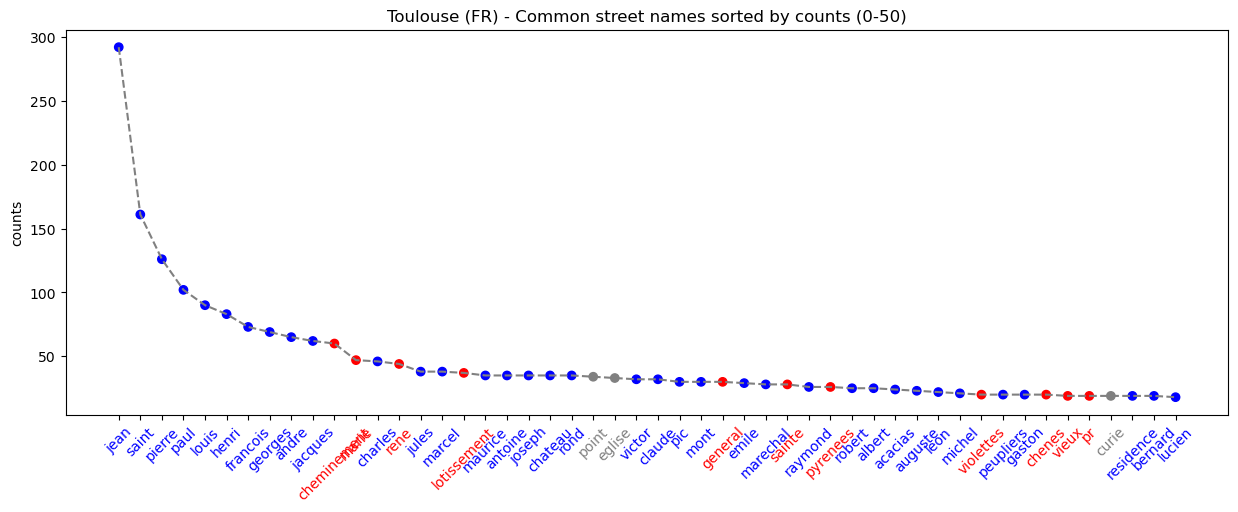

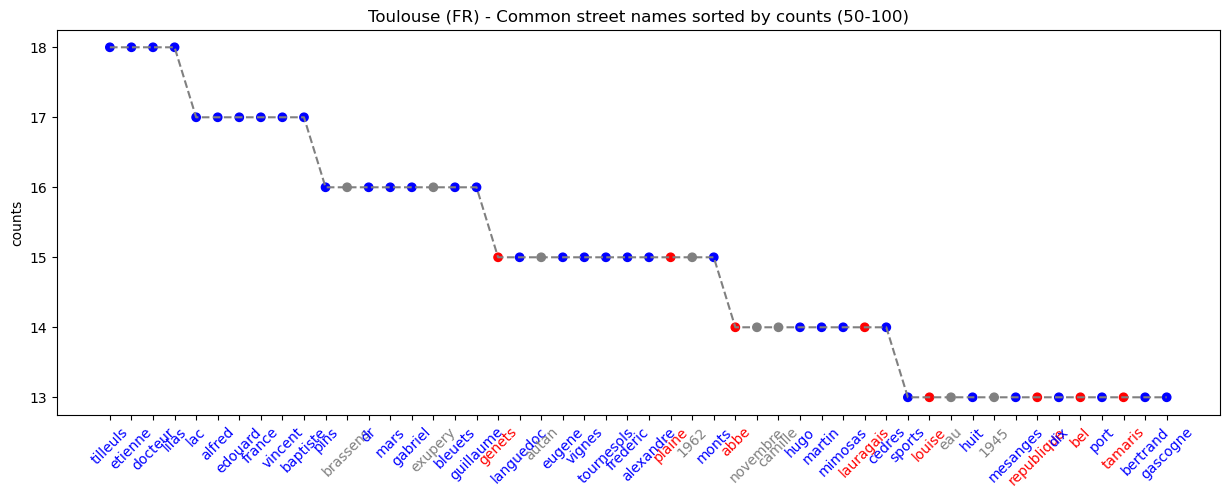

In [ ]:
plot_word_distr(offset=0, limit=50)
plot_word_distr(offset=50, limit=50)

In [ ]:
#Il apparait plus de nom feminin( aussi masculin identifie)

In [ ]:
#Gender bias - Street statistics
print(len(merged_resultat), 'streets in Toulouse')

8638 streets in Toulouse


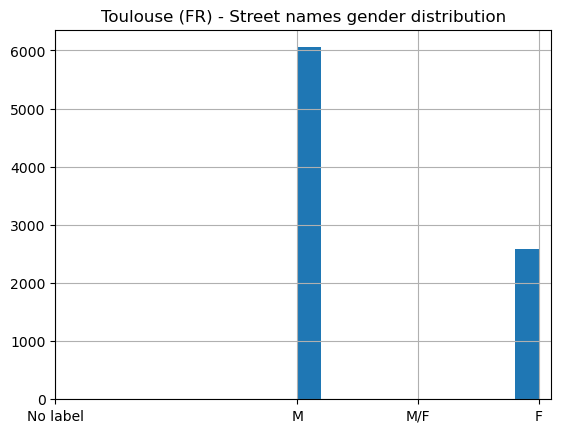

In [ ]:
 #plot distribution (street names gender distribution)
merged_resultat["genre"].hist()
plt.title("Toulouse (FR) - Street names gender distribution")
plt.xticks([0,1,1.5,2], ["No label", "M", "M/F", "F"])
plt.show()

In [ ]:
#la nouvelle carte
# rename label 0, 1, 2... for visualization
merged_resultat["genre"] = merged_resultat["genre"].astype(int)
merged_resultat.loc[merged_resultat["genre"]==0, "label"] = "None"
merged_resultat.loc[merged_resultat["genre"]==1, "label"] = "M"
merged_resultat.loc[merged_resultat["genre"]==2, "label"] = "F"
#df.loc[df["label"]==1.5, "label"] = "M/F"

In [ ]:
print(merged_resultat)

      code_insee                libelle  genre  code_postal  \
0          31003    allee des fenaisons      1        31280   
1          31003     allee des moissons      1        31280   
2          31003     allee des pyrenees      2        31280   
3          31003    allee des vendanges      1        31280   
4          31003  allee du mont vallier      1        31280   
...          ...                    ...    ...          ...   
8633       31588        rue saint aubin      1        31270   
8634       31588      rue saint laurent      1        31270   
8635       31588       rue saint perier      1        31270   
8636       31588     rue theodore monod      1        31270   
8637       31588        rue victor hugo      1        31270   

                  commune label  
0            AIGREFEUILLE     M  
1            AIGREFEUILLE     M  
2            AIGREFEUILLE     F  
3            AIGREFEUILLE     M  
4            AIGREFEUILLE     M  
...                   ...   ...  
8633 